In [6]:
import pandas as pd
import numpy as np
from pathlib import Path
import gc
%load_ext autoreload
%autoreload 2
from warnings import simplefilter
import time
from matplotlib import pyplot as plt
import seaborn as sns
from functions import stationary
simplefilter("ignore")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
dataset_dir = Path("../dataset")

## CONFIG 

In [13]:
filter_store_nbr = [str(i) for i in range(2)]
filter_family_list = ["AUTOMOTIVE","BABY CARE","SEAFOOD","BOOKS"]
train_start_date = "2013-01-01"
train_end_date = "2017-08-15"
test_start_date= "2017-01-01"
test_end_date= "2017-08-15"
from sktime.forecasting.base import ForecastingHorizon
fh = ForecastingHorizon(np.arange(1,17))
fh

ForecastingHorizon([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16], dtype='int32', is_relative=True)

In [14]:
train = pd.read_csv(dataset_dir / 'train.csv',                            
    usecols=['store_nbr', 'family', 'date', 'sales'],
    dtype={
        'store_nbr': 'category',
        'family': 'category',
        'sales': 'float32',
        'onpromotion': 'uint32'
    },
    parse_dates=['date'],
    infer_datetime_format=True,
)
# train['date'] = train.date.dt.to_period('D')
print(train.shape)

(3000888, 4)


In [11]:
stationary.adf_test(train["sales"])

Augmented Dickey-Fuller Test: 


MemoryError: Unable to allocate 1.57 GiB for an array with shape (70, 3000729) and data type float64

In [10]:
test = pd.read_csv(dataset_dir/'test.csv',
    dtype={
        'store_nbr': 'category',
        'family': 'category',
    },
    parse_dates=['date'],
    infer_datetime_format=True,
)
test['date'] = test.date.dt.to_period('D')


In [138]:
stores = pd.read_csv(dataset_dir / 'stores.csv')
oil = pd.read_csv(dataset_dir / 'oil.csv',parse_dates=["date"])
transactions =  pd.read_csv(dataset_dir / 'transactions.csv',parse_dates=["date"], dtype={'store_nbr':'category','transactions':'float32'})
holidays_events = pd.read_csv(dataset_dir / 'holidays_events.csv',parse_dates=["date"])

In [139]:
df_data = train
# df_data = df_data.merge(stores, how="left", on='store_nbr')   
# df_data = df_data.merge(oil, how="left", on='date')      
# df_data = df_data.merge(transactions, how="left", on=['date','store_nbr'])  
# df_data = df_data.merge(holidays_events,on='date',how='left')
df_data = df_data.rename(columns={'type_x' : 'store_type','type_y':'holiday_type'})

df_data.date = pd.to_datetime(df_data.date)
df_data['year'] = df_data['date'].dt.year
df_data['month'] = df_data['date'].dt.month
df_data['week'] = df_data['date'].dt.isocalendar().week
df_data['quarter'] = df_data['date'].dt.quarter
df_data['day_of_week'] = df_data['date'].dt.day_name()

In [140]:
# Aggregating the Time Series to a monthly scaled index
y = df_data[['date','sales']].copy()
y.set_index('date', inplace=True)
y.index = pd.to_datetime(y.index)
y = y.resample('1M').mean()
stationary.adf_test(y['sales'],title='') 

Augmented Dickey-Fuller Test: 
ADF test statistic      -1.574664
p-value                  0.496307
# lags used              1.000000
# observations          54.000000
critical value (1%)     -3.557709
critical value (5%)     -2.916770
critical value (10%)    -2.596222
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


In [11]:
train['date'] = train.date.dt.to_period('D')
train = train.set_index(["store_nbr","family","date"]).sort_index()

AttributeError: 'DataFrame' object has no attribute 'date'

In [134]:
train

,date,store_nbr,family,sales
0,2013-01-01,1,AUTOMOTIVE,0.000000
1,2013-01-01,1,BABY CARE,0.000000
2,2013-01-01,1,BEAUTY,0.000000
3,2013-01-01,1,BEVERAGES,0.000000
4,2013-01-01,1,BOOKS,0.000000
...,...,...,...,...
3000883,2017-08-15,9,POULTRY,438.132996
3000884,2017-08-15,9,PREPARED FOODS,154.552994
3000885,2017-08-15,9,PRODUCE,2419.729004
3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000000


In [143]:
store_sales_s = train.groupby('date').mean()

In [144]:
store_sales_s['time'] = np.arange(len(store_sales_s))
store_sales_s = store_sales_s.reset_index()

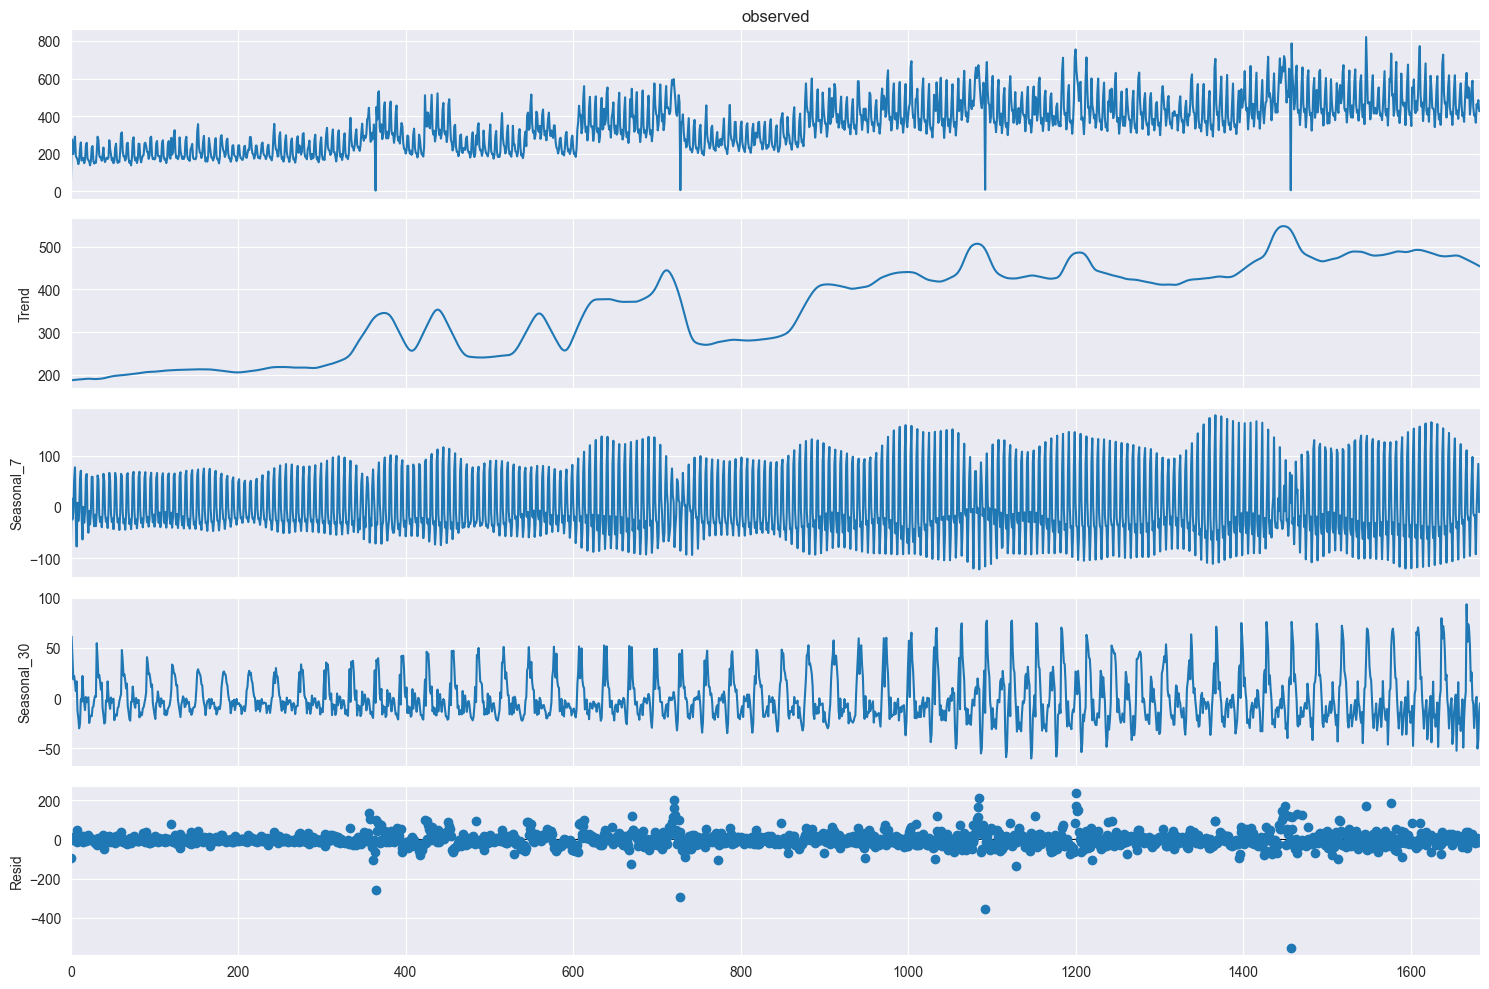

In [148]:
from statsmodels.tsa.seasonal import MSTL
# Decomposing sales data to check the seasonality in the sales using MSTL from statsmodels library
res = MSTL(store_sales_s['sales'], periods=(7, 30)).fit()
# increase the figure size
plt.rcParams['figure.figsize'] = (15, 10)
# Plot the results
res.plot()
plt.show()

In [147]:
sales = train.groupby(['date']).agg({"sales" : "mean"}).reset_index()
sales

,date,sales
0,2013-01-01,1.409438
1,2013-01-02,278.390808
2,2013-01-03,202.840195
3,2013-01-04,198.911163
4,2013-01-05,267.873260
...,...,...
1679,2017-08-11,463.733856
1680,2017-08-12,444.798309
1681,2017-08-13,485.768616
1682,2017-08-14,427.004730


<Axes: title={'center': 'Noise'}>

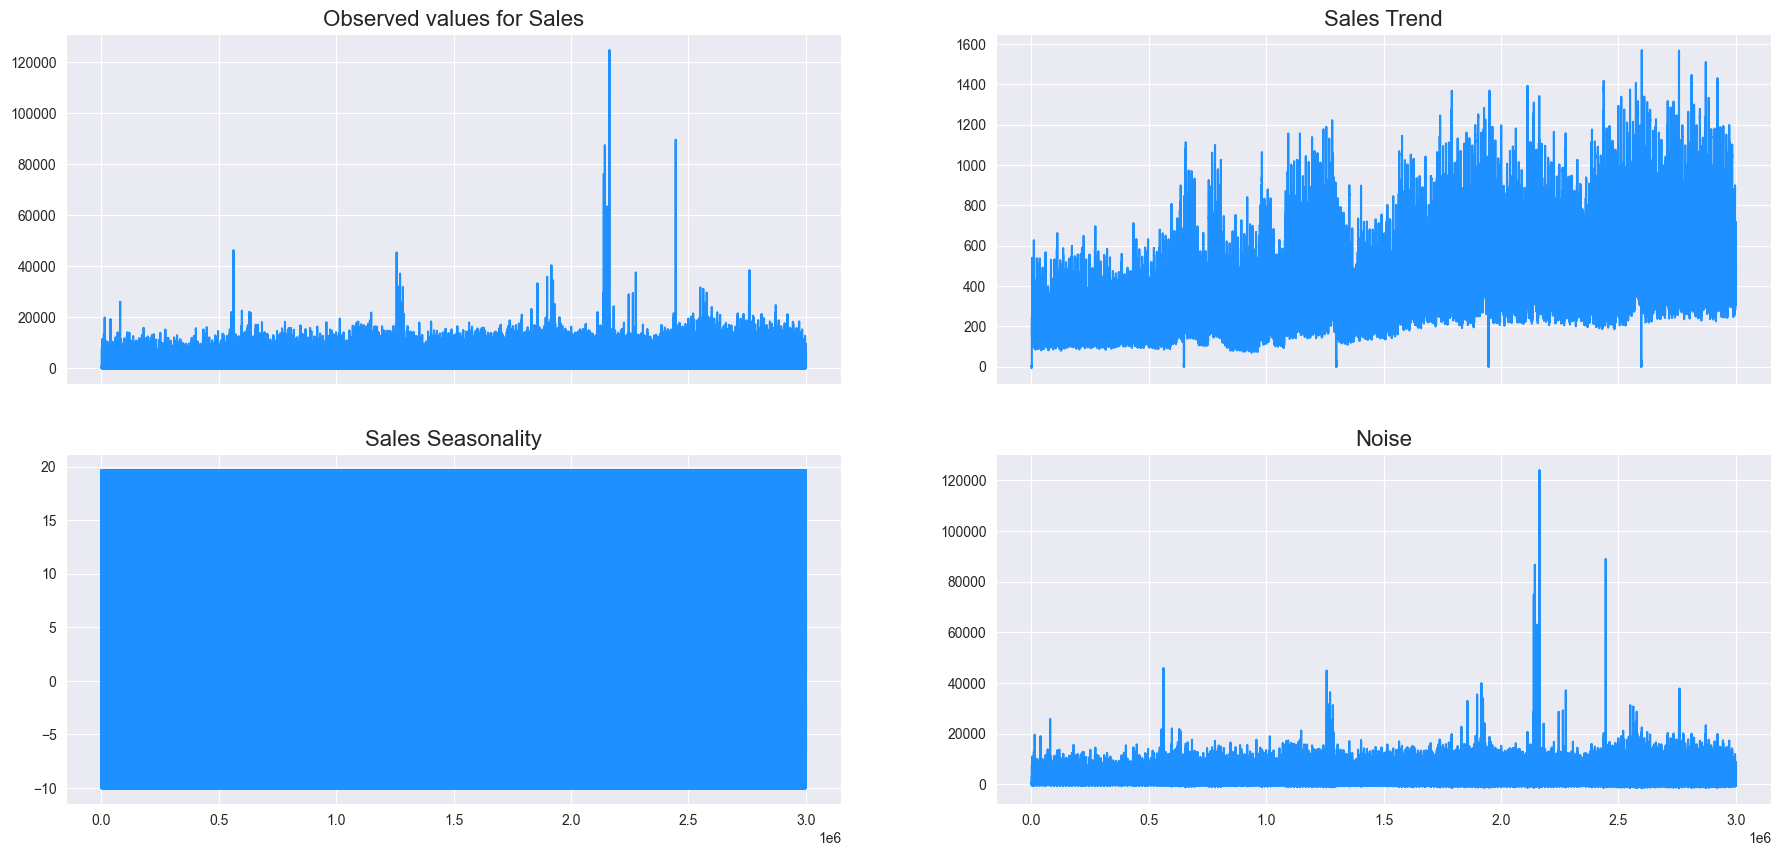

In [113]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomp = seasonal_decompose(df_data['sales'], period=365, model='additive', extrapolate_trend='freq')
fig, ax = plt.subplots(ncols=2, nrows=2, sharex=True, figsize=(22,10))
ax[0,0].set_title('Observed values for Sales', fontsize=16)
decomp.observed.plot(ax = ax[0,0], legend=False, color='dodgerblue')

ax[0,1].set_title('Sales Trend', fontsize=16)
decomp.trend.plot(ax = ax[0,1],legend=False, color='dodgerblue')

ax[1,0].set_title('Sales Seasonality', fontsize=16)
decomp.seasonal.plot(ax = ax[1,0],legend=False, color='dodgerblue')

ax[1,1].set_title('Noise', fontsize=16)
decomp.resid.plot(ax = ax[1,1],legend=False, color='dodgerblue')

In [100]:
def first_sale_detector(df: pd.DataFrame, feat: str, target: str, date: str):
    """
    Remove the records until a store sale the first product
    :param df: Data Frame
    :param feat: The hierarchical feature
    :param target: The target feature
    :param date: The reference date that data frame records start
    :return:
    """
    for i in np.sort(df[feat].unique()):
        first_sale = df.loc[(df[feat] == i) & (df[target] != 0.0)].date.iloc[0]
        if str(first_sale) != date:
            df = df[~((df[feat] == i) & (df.date < str(first_sale)))]
    return df

In [12]:
train = first_sale_detector(train, "store_nbr", "sales", "2013-01-01")
print(train.shape)

(2778831, 4)


In [13]:
train = (train
       .set_index(['store_nbr','family','date'])         # Setting MultiIndex to make unique identifiers for each 'sales' item
       .sort_index()
      )
train

sales
store_nbr family     date                 
1         AUTOMOTIVE 2013-01-02   2.000000
                     2013-01-03   3.000000
                     2013-01-04   3.000000
                     2013-01-05   5.000000
                     2013-01-06   2.000000
...                                    ...
9         SEAFOOD    2017-08-11  23.830999
                     2017-08-12  16.859001
                     2017-08-13  20.000000
                     2017-08-14  17.000000
                     2017-08-15  16.000000

[2778831 rows x 1 columns]

## SEASONALIY

In [20]:
def seasonal_plot(X, y, period, freq, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    palette = sns.color_palette("husl", n_colors=X[period].nunique(),)
    ax = sns.lineplot(
        x=freq,
        y=y,
        hue=period,
        data=X,
        ci=False,
        ax=ax,
        palette=palette,
        legend=False,
    )
    for line, name in zip(ax.lines, X[period].unique()):
        y_ = line.get_ydata()[-1]
        ax.annotate(
            name,
            xy=(1, y_),
            xytext=(6, 0),
            color=line.get_color(),
            xycoords=ax.get_yaxis_transform(),
            textcoords="offset points",
            size=14,
            va="center",
        )
    return ax

def plot_periodogram(ts, detrend='linear', ax=None):
    from scipy.signal import periodogram
    fs = pd.Timedelta(365,"D") / pd.Timedelta(1,"D")

    freqencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    if ax is None:
        _, ax = plt.subplots()
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)",
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax

Text(0.5, 1.0, 'Seasonal Plot (year/dayofyear)')

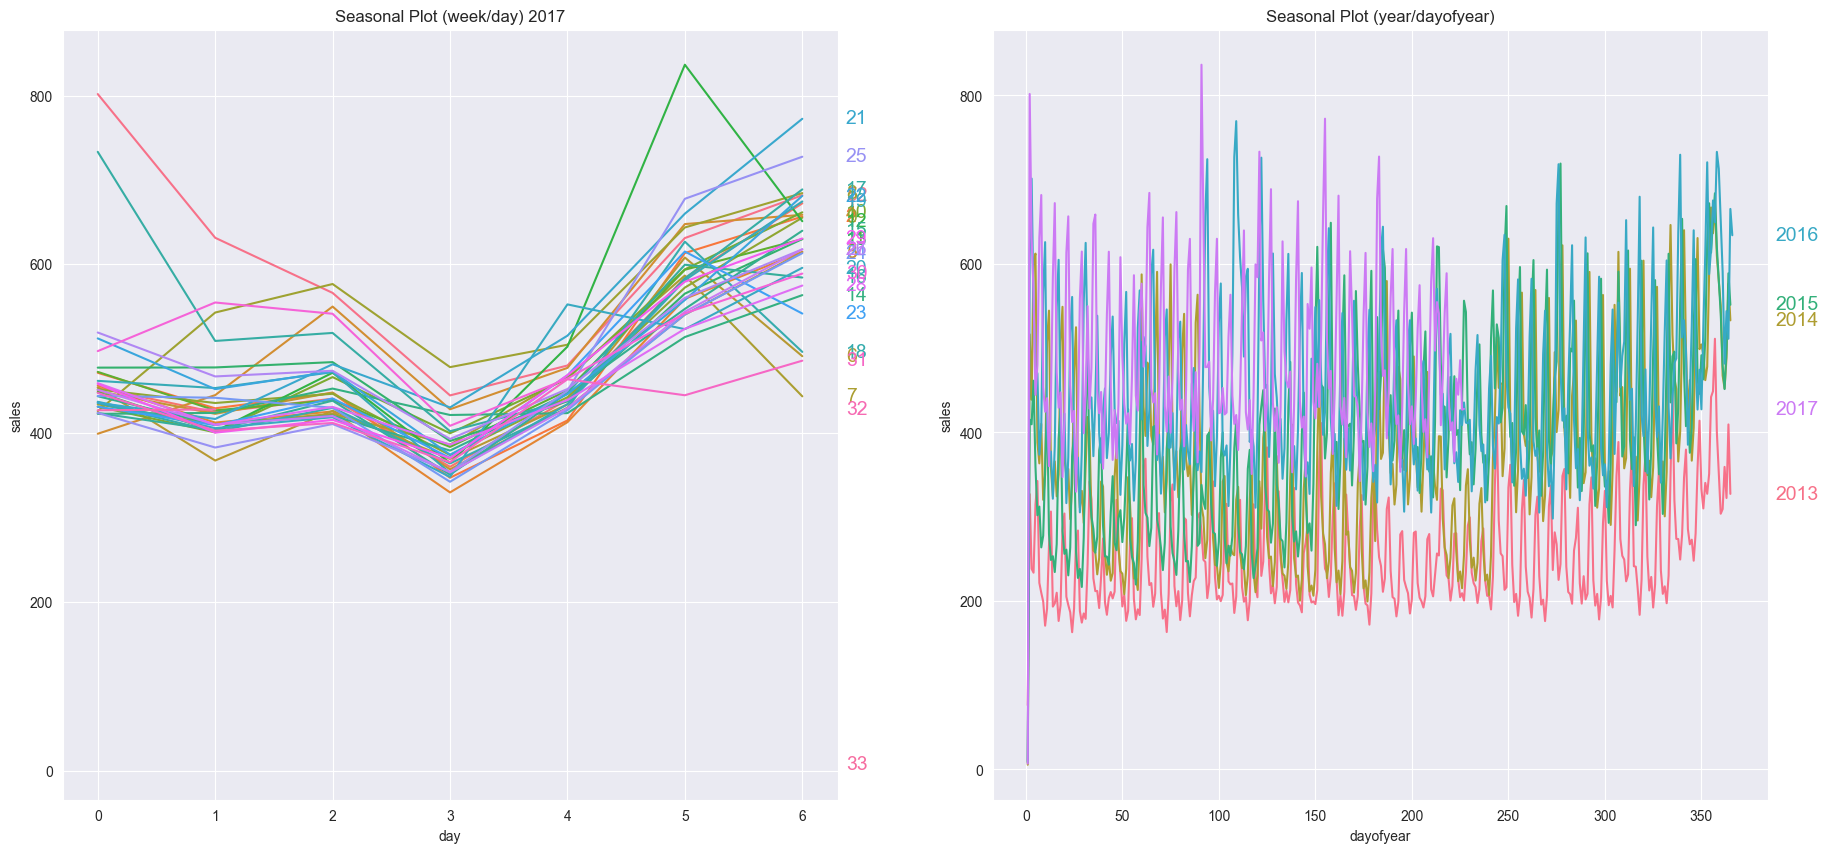

In [21]:
average_sales = (
    train
    .groupby('date').mean()
    .squeeze())
X = average_sales.to_frame()
X["week"] = X.index.week
X["day"] = X.index.dayofweek
X['year'] = X.index.year
X['dayofyear'] = X.index.dayofyear
fig,(ax0,ax1) = plt.subplots(1, 2, figsize=(22, 10))
seasonal_plot(X.loc['2017'], y='sales', period="week", freq="day", ax=ax0)
ax0.set_title('Seasonal Plot (week/day) 2017')
seasonal_plot(X, y="sales", period="year", freq="dayofyear", ax=ax1);
ax1.set_title('Seasonal Plot (year/dayofyear)')

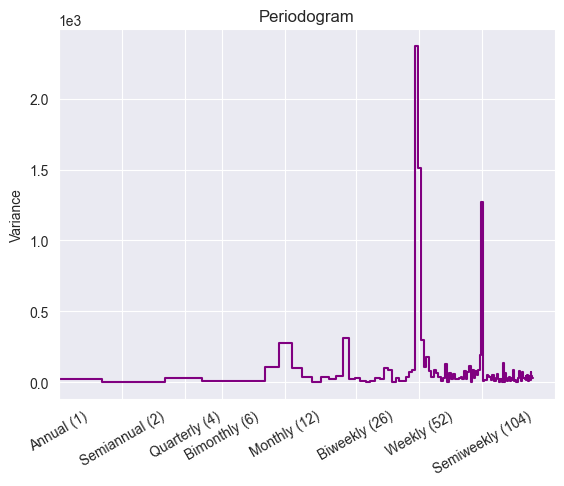

In [22]:
plot_periodogram(average_sales.loc['2017']);

📌 Interpret: both the seasonal plot and the periodogram suggest a strong weekly seasonality, and a weak annual seasonality. From the periodogram, it appears there may be some monthly and biweekly components as well. In fact, the notes to the Store Sales dataset say wages in the public sector are paid out biweekly, on the 15th and last day of the month -- a possible origin for these seasons.

## Moving Average 

In [33]:
def roll_mean_features(df: pd.DataFrame, windows, lags, min_periods=None, win_type="boxcar", use_noise:bool=False, fillna:str=None, downcast:bool=None) -> pd.DataFrame:
    def add_noise(x):
        return x + np.random.normal(size=len(x))
    for window_size in windows:
        for lag in lags:
            # df[f"SMA{window_size}_sales_lag{shift_value}"] = df.groupby(["store_nbr", "family"]).rolling(window_size,min_periods).sales.mean().shift(shift_value).values
            # 
            df[f"SMA{window_size}_sales_lag{lag}"] = df.groupby(["store_nbr", "family"])['sales'].transform(lambda x: x.shift(lag).rolling(window=window_size, min_periods=7, win_type=win_type).mean())
            if use_noise:
                df['sales_roll_mean_' + str(window_size)] = df.groupby(["store_nbr", "family"])['sales_roll_mean_' + str(window_size)].transform(add_noise)
    if fillna:
        df = df.fillna(method=fillna)
    if downcast:
        fcols = df.select_dtypes('float').columns
        icols = df.select_dtypes('integer').columns
        df[fcols] = df[fcols].apply(pd.to_numeric, downcast='float')
        df[icols] = df[icols].apply(pd.to_numeric, downcast='integer')
        df= df.astype('float32')
    return df

In [34]:
def lag_features(df, lags):
    for lag in lags:
        # 'store_nbr' ve 'family' sütunlarına göre 'sales' sütununun önceki değerlerini alarak 'sales_t-lag' sütununu oluştur
        df[f"sales_t-{lag}"] = df.groupby(["store_nbr", "family"])["sales"].transform(
            lambda x: x.shift(lag))
    return df

In [35]:
def ewm_features(df: pd.DataFrame, alphas:list, lags:list, fillna:str=None, downcast:bool=None) -> pd.DataFrame:
    for alpha in alphas:
        for lag in lags:
            feature_name = 'sales_ewm_alpha_' + str(alpha).replace(".", "") + '_lag_' + str(lag)
            df[feature_name] = df.groupby(["store_nbr", "family"])['sales'].\
                transform(lambda x: x.shift(lag).ewm(alpha=alpha, min_periods=1).mean())
    if fillna:
        df = df.fillna(method=fillna)
    if downcast:
        fcols = df.select_dtypes('float').columns
        icols = df.select_dtypes('integer').columns
        df[fcols] = df[fcols].apply(pd.to_numeric, downcast='float')
        df[icols] = df[icols].apply(pd.to_numeric, downcast='integer')
        df= df.astype('float32')
    return df

## Downcasting Float64>float32

In [12]:
def downcasting(df):
    fcols = df.select_dtypes('float').columns
    icols = df.select_dtypes('integer').columns
    df[fcols] = df[fcols].apply(pd.to_numeric, downcast='float')
    df[icols] = df[icols].apply(pd.to_numeric, downcast='integer')
    df= df.astype('float32')
    return df

sales               float32
SMA16_sales_lag4    float64
SMA16_sales_lag8    float64
SMA24_sales_lag4    float64
SMA24_sales_lag8    float64
dtype: object

In [87]:
def multi_level_filtering(df:pd.DataFrame, level0_filter:list=None, level1_filter:list=None, level2_filter:list=None, level3_filter:list=None, level4_filter:list=None):
    c0 = df.index.get_level_values(0).isin(level0_filter)
    c1 = df.index.get_level_values(1).isin(level1_filter)
    df = df[c0 & c1]
    c2 = None
    c3 = None
    if level2_filter:
        c2 = df.index.get_level_values(2).isin(level2_filter)
        df = df[df.index & c2]
    if level3_filter:
        c3 = df.index.get_level_values(3).isin(level3_filter)
        df = df[df.index & c3]
    # for level, filter in filter_dict.items():
    #     c = df.index.get_level_values(level).isin(filter)
    #     df = df[c]
    return df

In [88]:
def multi_level_data_date_filtering(df:pd.DataFrame, start, end):
    df = df[(df.index.get_level_values('date') >= start) & (df.index.get_level_values('date') <= end)]
    return df

In [89]:
test = pd.read_csv(dataset_dir/'test.csv',
    dtype={
        'store_nbr': 'category',
        'family': 'category',
    },
    parse_dates=['date'],
    infer_datetime_format=True,
)
test['date'] = test.date.dt.to_period('D')
test = (test
       .set_index(['store_nbr','family','date'])         # Setting MultiIndex to make unique identifiers for each 'sales' item
       .sort_index()
      )

In [90]:
def build_model(model_name,**kwargs):
    model = None
    if model_name == "ARIMA":
        from sktime.forecasting.arima import ARIMA
        model=ARIMA()
    elif model_name == "AutoARIMA":
        from sktime.forecasting.arima import AutoARIMA 
        model=AutoARIMA()
    elif model_name == "SARIMAX":
        from sktime.forecasting.sarimax import SARIMAX
        model=SARIMAX()
    elif model_name == "BATS":
        from sktime.forecasting.bats import BATS
        model=BATS()
    elif model_name == "TBATS":
        from sktime.forecasting.tbats import TBATS
        model=TBATS()
    elif model_name == "StatsForecastArima":
        from sktime.forecasting.statsforecast import StatsForecastAutoARIMA
        model=StatsForecastAutoARIMA()
    elif model_name == "StatsForecastTheta":
        from sktime.forecasting.statsforecast import StatsForecastAutoTheta
        model=StatsForecastAutoTheta()
    elif model_name == "ExpSmoothing":
        from sktime.forecasting.exp_smoothing import ExponentialSmoothing
        model=ExponentialSmoothing()
        
    elif model_name == "structural":
        from sktime.forecasting.structural import UnobservedComponents
        model = UnobservedComponents()

    return model

In [91]:
def train_model(model, y_train):
    model.fit(y_train)
    return model

In [92]:
def test_model(model, fh, y_test=None):
    y_pred = model.predict(fh)
    print(np.sum((y_pred["sales"]<0).values.ravel()))
    print(y_pred["sales"])
    y_pred["sales"] = np.abs(y_pred["sales"])
    
    if y_test is not None:
        from sklearn.metrics import mean_absolute_error, mean_squared_error, root_mean_squared_log_error,mean_absolute_percentage_error
    
        print(f"MAPE: {mean_absolute_percentage_error(y_test,y_pred)}")
        print(f'MAE:  {mean_absolute_error(y_test, y_pred)}')
        print(f'MSE:  {mean_squared_error(y_test, y_pred)}')
        print(f'RMSE: {np.sqrt(mean_squared_error(y_test, y_pred))}')
        #print(f"RMSLE_func: {root_mean_squared_log_error_func(y_test,y_pred)}")
        print(f"RMSLE: {root_mean_squared_log_error(y_test,y_pred)}")
    return y_pred

In [93]:
def save_model(model,model_name:str=None, experiment_name:str=''):
    import joblib
    from pathlib import Path
    import datetime
    experiments_dir = Path.cwd() / "experiments"
    experiments_dir.mkdir(exist_ok=True)
    start_time = datetime.datetime.now().strftime("%Y%m%d_%H%M")
    if model_name is None:
        try:
            model_name = model.__name__
        except AttributeError:
            print(f"No model name provided")
    model_path = experiments_dir / f"{model_name}_{start_time}_{experiment_name}"
    joblib.dump(model, f"{model_path}.pkl") 
    return 

In [94]:
def save_submission(model, fh, observation=''):
    y_pred = test_model(model, fh)
    y_pred["sales"]=y_pred["sales"].round(5)
    predicted_test = pd.concat([test,y_pred["sales"]],axis=1)
    predicted_test.sort_values("id",inplace=True)
    # predicted_test.to_csv(f"predicted_test_{observation}.csv")
    predicted_test.reset_index(inplace=True)
    predicted_test.drop(["store_nbr","family","onpromotion","date"],axis=1,inplace=True)
    y_pred = y_pred.append(zero_prediction).sort_index()
    predicted_test.set_index("id",inplace=True)
    predicted_test.to_csv(f"submissions/sample_submission_{observation}.csv")

In [95]:
def tune_model(self,model, param_grid, y_train):
    from sktime.forecasting.model_selection import ForecastingGridSearchCV
    from sktime.split import SlidingWindowSplitter

    cv = SlidingWindowSplitter(initial_window=int(len(y_train) * 0.8), window_length=20)
    gscv = ForecastingGridSearchCV(
        model, strategy="refit", cv=cv, param_grid=param_grid
    )
    gscv.fit(y_train)
    print(f"gscv best params: {gscv.best_params_}")
    return gscv

In [96]:
train

sales
store_nbr family     date                 
1         AUTOMOTIVE 2013-01-02   2.000000
                     2013-01-03   3.000000
                     2013-01-04   3.000000
                     2013-01-05   5.000000
                     2013-01-06   2.000000
...                                    ...
9         SEAFOOD    2017-08-11  23.830999
                     2017-08-12  16.859001
                     2017-08-13  20.000000
                     2017-08-14  17.000000
                     2017-08-15  16.000000

[2778831 rows x 1 columns]

## ARIMA

In [25]:
# arima = build_model("ARIMA")
# arima= train_model(arima,filtered_train)
# 0.55 score

## AUTOARIMA

In [ ]:
start_time = time.time()
AutoArima = build_model("AutoARIMA") #sp can be 52 or 104
AutoArima= train_model(AutoArima,train)
end_time = time.time()
runtime = end_time - start_time
print(f" takes to run: {runtime/60:.4f} minutes")

C:\Users\takyol\Desktop\projects\store_sales\venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\takyol\Desktop\projects\store_sales\venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\takyol\Desktop\projects\store_sales\venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\takyol\Desktop\projects\store_sales\venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [1]:
y_pred = test_model(AutoArima, fh)

NameError: name 'test_model' is not defined

## Zero Forecasting

In [223]:
c = train.groupby(["store_nbr","family"]).tail(15).groupby(["store_nbr","family"]).sales.sum().reset_index()
c = c[c.sales == 0].drop("sales",axis = 1)
c = c[c.family != "SCHOOL AND OFFICE SUPPLIES"]
c.shape
print("Shape of train before zero forecasting:", train.shape)
outer_join = train.reset_index().merge(c, how = 'outer', indicator = True)
train = outer_join[~(outer_join._merge == 'both')].drop('_merge', axis = 1)
train = train.set_index(['date', 'store_nbr', 'family']).sort_index()
del outer_join
gc.collect()
print("Shape of train after zero forecasting:", train.shape)
zero_prediction = []
for i in range(0, len(c)):
    zero_prediction.append(
        pd.DataFrame({
            "date":pd.date_range("2017-08-16", "2017-08-31").tolist(),
            "store_nbr":c.store_nbr.iloc[i],
            "family":c.family.iloc[i],
            "sales":0
        })
    )
zero_prediction = pd.concat(zero_prediction)
zero_prediction['date'] = zero_prediction.date.dt.to_period('D')
del c
gc.collect()
zero_prediction = zero_prediction.set_index(['date', 'store_nbr', 'family'])
zero_prediction.head()

Shape of train before zero forecasting: (2792072, 1)
Shape of train after zero forecasting: (2792196, 1)


,,,sales
date,store_nbr,family,
2017-08-16,1,BABY CARE,0
2017-08-17,1,BABY CARE,0
2017-08-18,1,BABY CARE,0
2017-08-19,1,BABY CARE,0
2017-08-20,1,BABY CARE,0


In [225]:
zero_prediction.reset_index(inplace=True)
zero_prediction= (zero_prediction.set_index(['store_nbr','family','date']).sort_index())
for column in y_pred.columns:
    zero_prediction[column]=0
zero_prediction.head()

TypeError: unhashable type: 'slice'

In [152]:
y_pred.update(zero_prediction)
y_pred["sales"]=y_pred["sales"].round(5)
y_pred

sales
store_nbr family     date                 
1         AUTOMOTIVE 2017-08-16   4.704427
                     2017-08-17   4.541561
                     2017-08-18   4.497597
                     2017-08-19   4.497597
                     2017-08-20   4.497597
...                                    ...
9         SEAFOOD    2017-08-27  19.136554
                     2017-08-28  15.688178
                     2017-08-29  17.786441
                     2017-08-30  20.143732
                     2017-08-31  16.946926

[28512 rows x 1 columns]

In [155]:
predicted_test = pd.concat([test,y_pred["sales"]],axis=1)
predicted_test.sort_values("id",inplace=True)
# predicted_test.to_csv(f"predicted_test_{observation}.csv")
predicted_test.reset_index(inplace=True)
predicted_test.drop(["store_nbr","family","onpromotion","date"],axis=1,inplace=True)
predicted_test.set_index("id",inplace=True)
predicted_test.to_csv(f"submissions/sample_submission.csv")

In [ ]:
## ACF & PACF For each family